# 情感分析

In [26]:
"""
导入需要的模块
"""
# 1.分词
import jieba
# 2. 词性识别
import jieba.posseg as pseg
# 3.数据处理
import pandas as pd
# 4.数学计算
import numpy as np
# 5.系统模块
import os
# 6.画图
from matplotlib import pyplot as plt
# 7.便捷画图
import seaborn as sns
# 8.词云图
from wordcloud import WordCloud
# 9.正则
import re
# 10.为了在图片上可以使用中文
from pylab import *
# 设置字体
sns.set(font_scale=1.2)
# 设置线条
sns.set(rc={"lines.linewidth":1})
# 设置风格
sns.set_style("whitegrid")
# 设置中文
mpl.rcParams['font.sans-serif']=u'SimHei'
plt.rcParams['axes.unicode_minus']=False

# 不显示警告
import warnings
warnings.filterwarnings('ignore')

In [27]:
# 查看数据情况
# 获取顺序的excel名称
path1="./好评"
path2="./差评"
path1_list=os.listdir(path1)
path1_list.sort(key=lambda x:x.split(",")[0])
path2_list=os.listdir(path2)
path2_list.sort(key=lambda x:x.split(",")[0])

# 读取并合并数据
df=pd.DataFrame(columns=['商品id','评论时间','评论内容','点赞数','评论打分'])
for path in path1_list:
    data=pd.read_excel('./好评/'+path)[['商品id','评论时间','评论内容','点赞数','评论打分']]
    df=pd.concat([df,data],ignore_index=True)
for path in path2_list:
    data=pd.read_excel('./差评/'+path)[['商品id','评论时间','评论内容','点赞数','评论打分']]
    df=pd.concat([df,data],ignore_index=True)

In [28]:
# 观察值的情况
print(df['商品id'].unique())
print(df['点赞数'].unique())
print(df['评论打分'].unique())


[100004553486 100005003581 100006077298 100009148729 100009779201]
[2 12 1 5 4 0 8 11 3 31 6 10 26 17 9 15 22 7]
[5 1]


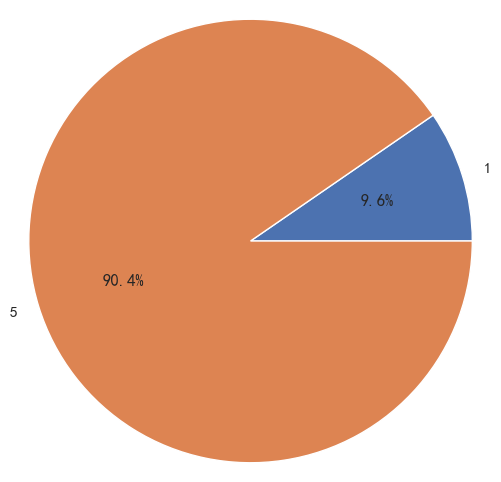

In [29]:
# # 查看评论打分分布
df_evaluate=df["评论打分"].reset_index()
df_evaluate.columns=['Count','评论打分']
df_evaluate=df_evaluate.groupby('评论打分').agg('count').reset_index()
df_evaluate.sort_values(by='Count',inplace=True,ascending=True)

plt.figure(figsize=(8,6))
plt.pie(
    df_evaluate['Count'],
    labels=df_evaluate['评论打分'],
    autopct='%1.1f%%',
    radius=1.2
)
plt.show()

In [30]:
"""
为了方便，将5处理为1，将1处理为0
"""
#df['评论打分'] = df['评论打分'].map(lambda x: 1 if x == 5 else 0)

In [78]:
# 观察每个商品好评与差评的数量分布
# 将商品id列变为str类型，后续画图不能正常绘制

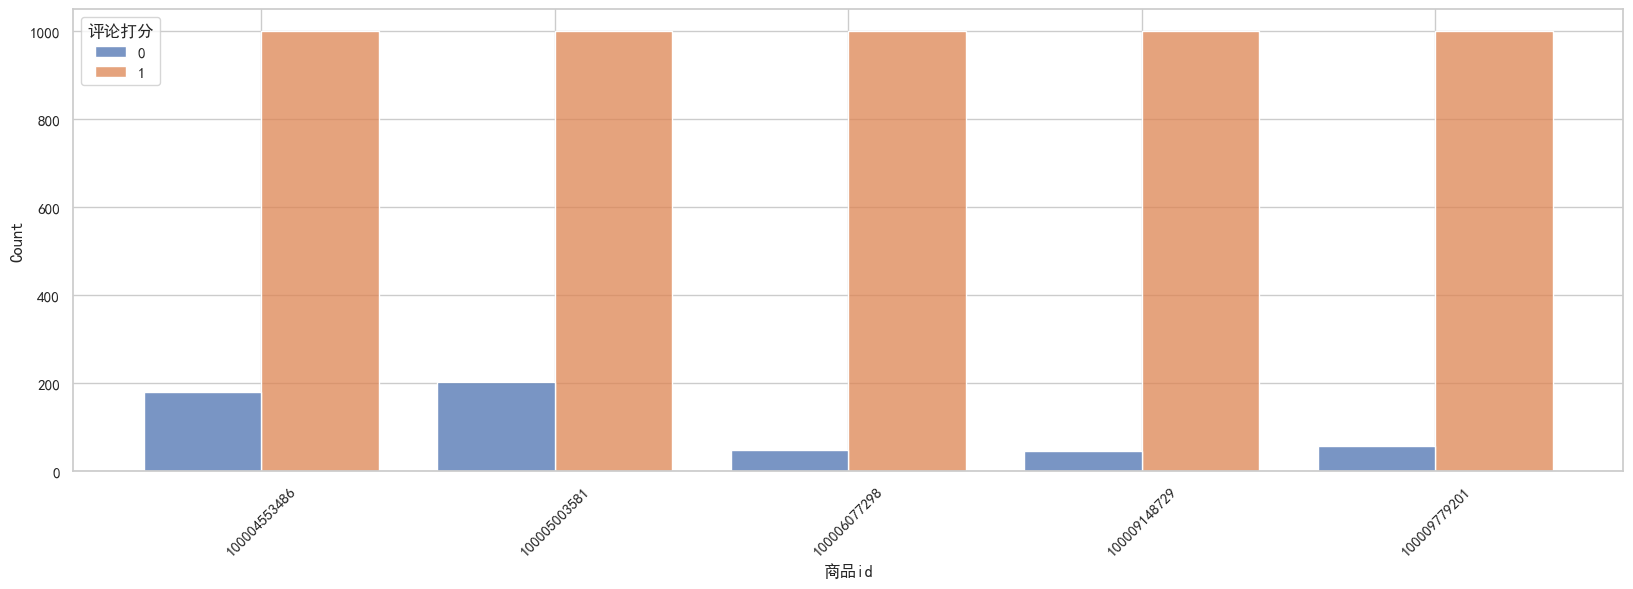

In [31]:
df['商品id']=df['商品id'].apply(str)
plt.figure(figsize=(20,6))
sns.histplot(
    # 数据源
    data=df,
    # x轴
    x='商品id',
    # 用于区分数据系列
    hue='评论打分',
    # multiple='layer', 用于设置分组数据的展现形式。有layer、dodge、stack、fill四种设置
    multiple='dodge', # 绘制多个直方图，通过错开放式进行显示
    # 用于设置条形图的宽度相对于组距的宽度，默认为1，即二者相等。设置为0.8的效果。
    shrink=0.8
)
# x轴进行标签旋转90度
plt.xticks(rotation=45)
plt.show()

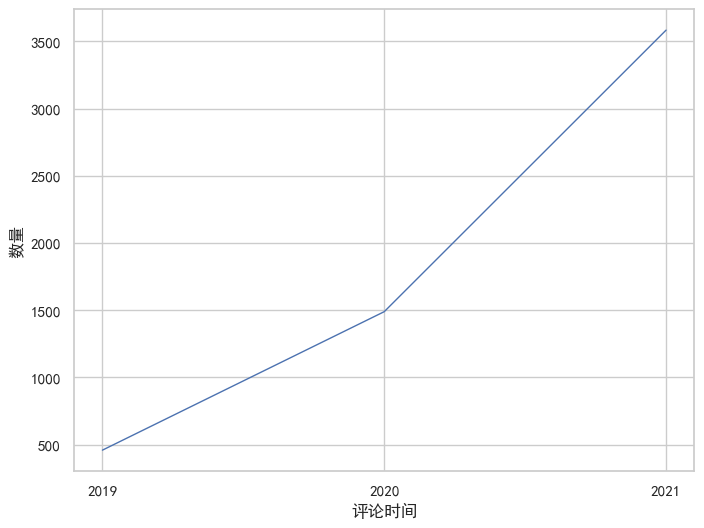

In [32]:
# 观察每年的商品评论数量
df['评论时间']=df['评论时间'].map(lambda x:x.split('-')[0])
df_time=df['评论时间'].reset_index()
df_time.columns=['Count','评论时间']
df_time=df_time.groupby('评论时间').agg('count').reset_index()
df_time.sort_values(by='评论时间',inplace=True,ascending=True)
# 画图
plt.figure(figsize=(8,6))
sns.lineplot(
    data=df_time,
    x='评论时间',
    y='Count'
)
# 该函数为绘图窗口中的纵轴（y轴）方向上显示一个“标签” 
plt.ylabel('数量')
plt.show()

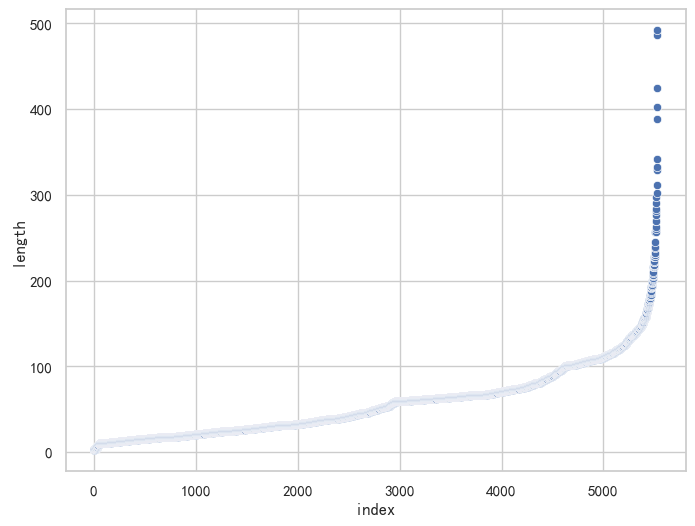

In [33]:
# 观察评论的长度分布
length=pd.DataFrame(columns=['length'])
for index,row in df.iterrows():
    length.loc[index]=len(row['评论内容'])

# 绘制图像
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=length,
    x=range(length.shape[0]),
    y=np.sort(length['length'])
)
plt.xlabel('index')
plt.ylabel('length')
plt.show()


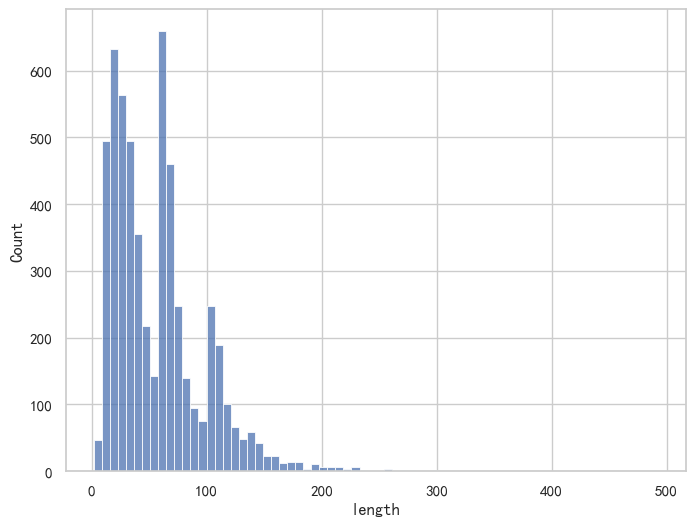

In [34]:

# 观察评论长度大小分布情况
plt.figure(figsize=(8,6))
sns.histplot(
    data=length,
    x='length',
    bins=70
)
plt.show()

In [35]:
# 去掉长度过短、过长的评论
# 大于300:可能是随便复制的
# 小于10:太短没有意义
print(len(df[df['评论内容'].str.len()>300]))
print(len(df[df['评论内容'].str.len()<10]))

df.drop(df[df['评论内容'].str.len()>300].index,inplace=True)
df.drop(df[df['评论内容'].str.len()<10].index,inplace=True)

10
63


In [36]:
# 删除重复值
# keep='first'  保留重复数据第一条
df=df.drop_duplicates(subset='评论内容',keep='first')

In [37]:
# 删除标点符号或英文字母过多得评论
# 标点符号比文字多，那么需要删除
# 英文字母比中文多，需要删除
count=[] # 记录需要删除的内容，根据索引index
for index,row in df.iterrows():
    # 中文数量
    chinese=0
    other=0  # 其他字符的数量
    for i in row['评论内容']:
        # 在Unicode编码中,汉字的编码范围是\u4e00到\u9fa5。
        if '\u4e00'<=i<='\u9fa5':
            chinese+=1
        else:
            other+=1
    # 判断中文小于其他字符
    if chinese<other:
        count.append(index)
# 根据索引进行删除内容
for index in count:
    df.drop(index,inplace=True)
print(df)

              商品id  评论时间                                               评论内容  \
0     100004553486  2021  喝了好几年蓝胖子了，好喝着呢，非常非常好喝，大人孩子都喝，每次都买好几桶，倍儿香！浓浓奶香味...   
1     100004553486  2020  收到货了，快递很给力，日期也很新鲜。入水即溶，虽然是脱脂奶粉，但是一点也不影响口感，喝完还会...   
2     100004553486  2021  第一次买蓝胖子，奶粉很细，很香比之前喝的伊利，雀巢都香，不知道是不是加了东西，甜度也比较高，...   
3     100004553486  2021  这款美可卓奶粉口感还是非常好的，奶味非常香，每天早晚一杯是雷打不动的，不管老年中年小孩都能喝...   
4     100004553486  2020  宝贝收到了，非常喜欢，看着外包装瓶，就有食欲，非常时期，拍了就发货，第二天就到了，感谢京东的...   
...            ...   ...                                                ...   
5526  100009779201  2021  上个月左右给老爸买四罐奶粉，后给邻居买两罐，昨天又给老爸买四罐，今准备给公公也买，唉，价格就...   
5527  100009779201  2021  中国的奶粉我也不想说什么了，这个是送给老人的，我也不想评价，反正中国有的就是#，没啥意思。给...   
5528  100009779201  2021  老头喝了拉肚子。。。。。一天拉好多次。怎么回事啊？？？？估计是乳糖不耐受，一天拉好多次。后面...   
5529  100009779201  2021  奶粉本身没有问半天，不错，就是蒙牛自营店客服让人不满意，之前明确问生产日期是6月份左右，收到...   
5530  100009779201  2021  差评！店家完全的对消费者不负责任，第一个差评送给你们了，包装太敷衍，外面也不用快递盒包装，就...   

     点赞数  评论打分  
0      2     1  
1     12     1  


In [38]:

# 处理HTML符号，实体编码替换
"""
&lt;
&gt;
&amp;
&quot;
&reg;
&copy;
&trade;
&ensp;
&emsp;
&nbsp;
"""
# replace()
df['评论内容']=df['评论内容'].str.replace('&amp','')
# replace()
df['评论内容']=df['评论内容'].str.replace('&lt','')
# replace()
df['评论内容']=df['评论内容'].str.replace('&gt','')

In [16]:
# 处理 星号 * ，
df_temp=df[df['评论内容'].str.contains('\*')]
regex=re.compile('[*]+')
# # # 匹配
df['评论内容']=df['评论内容'].str.replace(regex,'*')
df

ValueError: Cannot use a compiled regex as replacement pattern with regex=False

In [39]:
# 将 ‘京东’、’奶粉‘ 字样去掉（所有商品都是奶粉，都来自于京东）
info=re.compile('京东|奶粉')
df['评论内容']=df['评论内容'].map( lambda x: info.sub('',x))
print(df[df['评论内容'].str.contains('奶粉')])

Empty DataFrame
Columns: [商品id, 评论时间, 评论内容, 点赞数, 评论打分]
Index: []


In [103]:
# 根据每行的评论内容，调用分词函数，进行转换

In [40]:
# 保留中文  英文字母  数字 星号
def fenci(text):
    cut_word=[i for i in list(jieba.cut(text)) if '\u0030'<=i<='\u0039' or '\u0061'<=i<='\u007a' or '\u0041'<=i<='\u005a' or i=='\u002A' or '\u4e00'<=i<='\u9fff' ]
    content=' '.join(cut_word)
    return content

# # 添加一列数据
df['分词后']=''
# 提取每行评论的内容
for index in range(len(df)):
    df['分词后'].iloc[index]=fenci(df['评论内容'].iloc[index])

df


,商品id,评论时间,评论内容,点赞数,评论打分,分词后
0,100004553486,2021,喝了好几年蓝胖子了，好喝着呢，非常非常好喝，大人孩子都喝，每次都买好几桶，倍儿香！浓浓奶香味...,2,1,喝 了 好几年 蓝 胖子 了 好喝 着 呢 非常 非常 好喝 大人 孩子 都 喝 每次 都 ...
1,100004553486,2020,收到货了，快递很给力，日期也很新鲜。入水即溶，虽然是脱脂，但是一点也不影响口感，喝完还会回购...,12,1,收到 货 了 快递 很 给 力 日期 也 很 新鲜 入水 即 溶 虽然 是 脱脂 但是 一点...
2,100004553486,2021,第一次买蓝胖子，很细，很香比之前喝的伊利，雀巢都香，不知道是不是加了东西，甜度也比较高，最多...,1,1,第一次 买 蓝 胖子 很 细 很香 比 之前 喝 的 伊利 雀巢 都 香 不 知道 是不是 ...
3,100004553486,2021,这款美可卓口感还是非常好的，奶味非常香，每天早晚一杯是雷打不动的，不管老年中年小孩都能喝，就...,2,1,这款 美可卓 口感 还是 非常 好 的 奶味 非常 香 每天 早晚 一杯 是 雷打不动 的 ...
4,100004553486,2020,宝贝收到了，非常喜欢，看着外包装瓶，就有食欲，非常时期，拍了就发货，第二天就到了，感谢的服务...,5,1,宝贝 收到 了 非常 喜欢 看着 外包装 瓶 就 有 食欲 非常 时期 拍 了 就 发货 第...
...,...,...,...,...,...,...
5526,100009779201,2021,上个月左右给老爸买四罐，后给邻居买两罐，昨天又给老爸买四罐，今准备给公公也买，唉，价格就不一...,1,0,上个月 左右 给 老爸 买四罐 后 给 邻居 买 两罐 昨天 又 给 老爸 买四罐 今 准备...
5527,100009779201,2021,中国的我也不想说什么了，这个是送给老人的，我也不想评价，反正中国有的就是#，没啥意思。给个差...,0,0,中国 的 我 也 不想 说 什么 了 这个 是 送给 老人 的 我 也 不想 评价 反正 中...
5528,100009779201,2021,老头喝了拉肚子。。。。。一天拉好多次。怎么回事啊？？？？估计是乳糖不耐受，一天拉好多次。后面...,0,0,老头 喝 了 拉肚子 一天 拉好 多次 怎么回事 啊 估计 是 乳糖 不 耐受 一天 拉好 ...
5529,100009779201,2021,本身没有问半天，不错，就是蒙牛自营店客服让人不满意，之前明确问生产日期是6月份左右，收到货看...,2,0,本身 没有 问 半天 不错 就是 蒙牛 自营 店 客服 让 人 不 满意 之前 明确 问 生...


In [41]:
# 利用机器学习和文本挖掘技术完成情感分析模型搭建

#- 逻辑回归
#- 多项式贝叶斯
#- 随机森林

# CountVectorizer 将文字转换为数字 每个单词在文档中出现的次数，作用：将文本文档转换为计算的稀疏矩阵
from sklearn.feature_extraction.text import CountVectorizer
# 计算词频
from sklearn.feature_extraction.text import TfidfTransformer

def tf_idf_matrix(words):
    counter=CountVectorizer(max_df=0.9,min_df=0.001)
    counts=counter.fit_transform(words) # 将内容转换为计数的稀疏矩阵
    tfidfer=TfidfTransformer()
    tfidf=tfidfer.fit_transform(counts)
    data=tfidf.toarray()
    return data

# 划分数据，随机划分训练集和测试集
from sklearn.model_selection import train_test_split
# 从样本里面随机按照比例选取，训练数据和测试数据
x=tf_idf_matrix(df['分词后'])
#x_train 划分的训练集数据
# x_test 划分的测试集数据
# y_train：划分的训练集标签
# y_test： 划分的测试集标签
x_train,x_test,y_train,y_test=train_test_split(x,df['评论打分'],test_size=0.2,random_state=1)
print('训练集数量{},测试集数量{}'.format(len(x_train),len(x_test)))

训练集数量4332,测试集数量1084


In [42]:
print(x_train)
print(y_train)
# 特征数量
# 通过上面的数据找出重要特征
# 使用RandomForestClassifier决策树分类器来找一下重要特征
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=1)
# rfc.fit( x_train, y_train)
# feature_importances_: 使用这个属性，来评估特征对模型预测能力的重要性
# 可以帮助我们了解构建模型时，各个特征对最终预测结果的贡献程度
# importances=rfc.feature_importances_
# 对特征重要性数组进行排序，返回排序后的索引数组
# indices=np.argsort(importances)[::1]
# argsort: 是返回从小到大排序之后的元素对应索引
# sort是将从小到大排序之后的内容

# indices





[[0.         0.         0.16951811 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
13      1
1255    1
4892    1
1336    1
2984    1
       ..
907     1
5259    0
4008    1
236     1
5223    0
Name: 评论打分, Length: 4332, dtype: int64


In [43]:
# 利用## 掘出正负文本中得关键点情况

# 主要思路：

# - 对文档分词，找出文档中得情感词、否定词以及程度副词
# - 然后判断每个情感词之前是否有否定词及程度副词，将他之前得否定词和程度副词划分为一个组
# - 如果有否定词将情感词得情感权重值乘以-1，如果有程度副词就乘以程度副词得程度值
# - 最后所有组得得分加起来，大于0得归于正向，小于0得归于负向，得分得绝对值大小反映了积极或消极得程度

# 读取否定词文件和程度副词文件
negation=pd.read_csv('./工具/否定词.txt',header=None,encoding="utf-8")
print(negation)
# 读取程度副词
adv=pd.read_csv('./工具/程度副词X.txt',header=None,sep=',',encoding='utf-8')
# 读取BosonNLP_sentiment_score
emotion=pd.read_csv('./工具/BosonNLP_sentiment_score.txt',header=None,sep=' ',encoding='utf-8')

# 分布变成list和dict
negation_list=negation[0].tolist()
adv1=adv[0].tolist()
adv2=adv[1].tolist()

adv_dict=dict(zip(adv1,adv2))
emotion1=emotion[0].tolist()
emotion2=emotion[1].tolist()
emotion_dict=dict(zip(emotion1,emotion2))

       0
0     不大
1   不丁点儿
2     不甚
3    不怎么
4      聊
..   ...
66    禁止
67     忌
68    拒绝
69    杜绝
70     弗

[71 rows x 1 columns]


In [44]:
# 计算评论情感分值
def score_sentiment(negation_list,adv_dict,emotion_dict,words):
    # 提取每个词汇
    word_list=words.split(' ')
    # 最终得分
    score=0
    # 初始分数
    W=1
    flag=False
    for i in range(len(word_list)):
        if flag==True: 
            W=1
        if word_list[i] in negation_list: # 判断如果某个词在否定词内
            flag=False
            W=-1*W
        elif word_list[i] in adv_dict: # 程度副词
            flag=False
            W=W*adv_dict.get(word_list[i])
        elif word_list[i] in emotion_dict: # 情感词汇
            flag=True
            score +=W*emotion_dict.get(word_list[i])
    return score
df['情感词典预测']=''
for i in range(len(df)):
    res=score_sentiment(negation_list,adv_dict,emotion_dict,df['分词后'].iloc[i])
    if res>0:
        df['情感词典预测'].iloc[i]=1
    else:
        df['情感词典预测'].iloc[i]=0

df

,商品id,评论时间,评论内容,点赞数,评论打分,分词后,情感词典预测
0,100004553486,2021,喝了好几年蓝胖子了，好喝着呢，非常非常好喝，大人孩子都喝，每次都买好几桶，倍儿香！浓浓奶香味...,2,1,喝 了 好几年 蓝 胖子 了 好喝 着 呢 非常 非常 好喝 大人 孩子 都 喝 每次 都 ...,1
1,100004553486,2020,收到货了，快递很给力，日期也很新鲜。入水即溶，虽然是脱脂，但是一点也不影响口感，喝完还会回购...,12,1,收到 货 了 快递 很 给 力 日期 也 很 新鲜 入水 即 溶 虽然 是 脱脂 但是 一点...,1
2,100004553486,2021,第一次买蓝胖子，很细，很香比之前喝的伊利，雀巢都香，不知道是不是加了东西，甜度也比较高，最多...,1,1,第一次 买 蓝 胖子 很 细 很香 比 之前 喝 的 伊利 雀巢 都 香 不 知道 是不是 ...,1
3,100004553486,2021,这款美可卓口感还是非常好的，奶味非常香，每天早晚一杯是雷打不动的，不管老年中年小孩都能喝，就...,2,1,这款 美可卓 口感 还是 非常 好 的 奶味 非常 香 每天 早晚 一杯 是 雷打不动 的 ...,1
4,100004553486,2020,宝贝收到了，非常喜欢，看着外包装瓶，就有食欲，非常时期，拍了就发货，第二天就到了，感谢的服务...,5,1,宝贝 收到 了 非常 喜欢 看着 外包装 瓶 就 有 食欲 非常 时期 拍 了 就 发货 第...,1
...,...,...,...,...,...,...,...
5526,100009779201,2021,上个月左右给老爸买四罐，后给邻居买两罐，昨天又给老爸买四罐，今准备给公公也买，唉，价格就不一...,1,0,上个月 左右 给 老爸 买四罐 后 给 邻居 买 两罐 昨天 又 给 老爸 买四罐 今 准备...,0
5527,100009779201,2021,中国的我也不想说什么了，这个是送给老人的，我也不想评价，反正中国有的就是#，没啥意思。给个差...,0,0,中国 的 我 也 不想 说 什么 了 这个 是 送给 老人 的 我 也 不想 评价 反正 中...,1
5528,100009779201,2021,老头喝了拉肚子。。。。。一天拉好多次。怎么回事啊？？？？估计是乳糖不耐受，一天拉好多次。后面...,0,0,老头 喝 了 拉肚子 一天 拉好 多次 怎么回事 啊 估计 是 乳糖 不 耐受 一天 拉好 ...,0
5529,100009779201,2021,本身没有问半天，不错，就是蒙牛自营店客服让人不满意，之前明确问生产日期是6月份左右，收到货看...,2,0,本身 没有 问 半天 不错 就是 蒙牛 自营 店 客服 让 人 不 满意 之前 明确 问 生...,1


In [45]:
# 计算正确率
num=0
for index,row in df.iterrows():
    if row['评论打分']==row['情感词典预测']:
        num+=1

print("正确率：",num/len(df))


正确率： 0.9289143279172821


不错    0.045533
非常    0.041832
喜欢    0.034909
味道    0.033317
好喝    0.030072
一直    0.028185
这个    0.027199
购买    0.025766
物流    0.024738
很快    0.023469
口感    0.022661
包装    0.022451
营养    0.019503
孩子    0.019171
价格    0.019146
可以    0.018576
活动    0.018096
值得    0.018032
牛奶    0.016846
特别    0.016402
快递    0.016338
回购    0.015954
正品    0.015329
老人    0.015300
宝宝    0.015243
速度    0.015206
香味    0.015040
方便    0.014908
实惠    0.014858
收到    0.014756
满意    0.014708
品牌    0.014068
质量    0.013310
比较    0.013293
还是    0.013188
没有    0.013187
这款    0.012749
还会    0.012704
东西    0.012609
多次    0.012455
一杯    0.012433
信赖    0.012284
奶味    0.012258
牌子    0.012162
真的    0.011751
浓郁    0.011690
已经    0.011405
而且    0.011090
推荐    0.011087
喝完    0.010999
dtype: float64


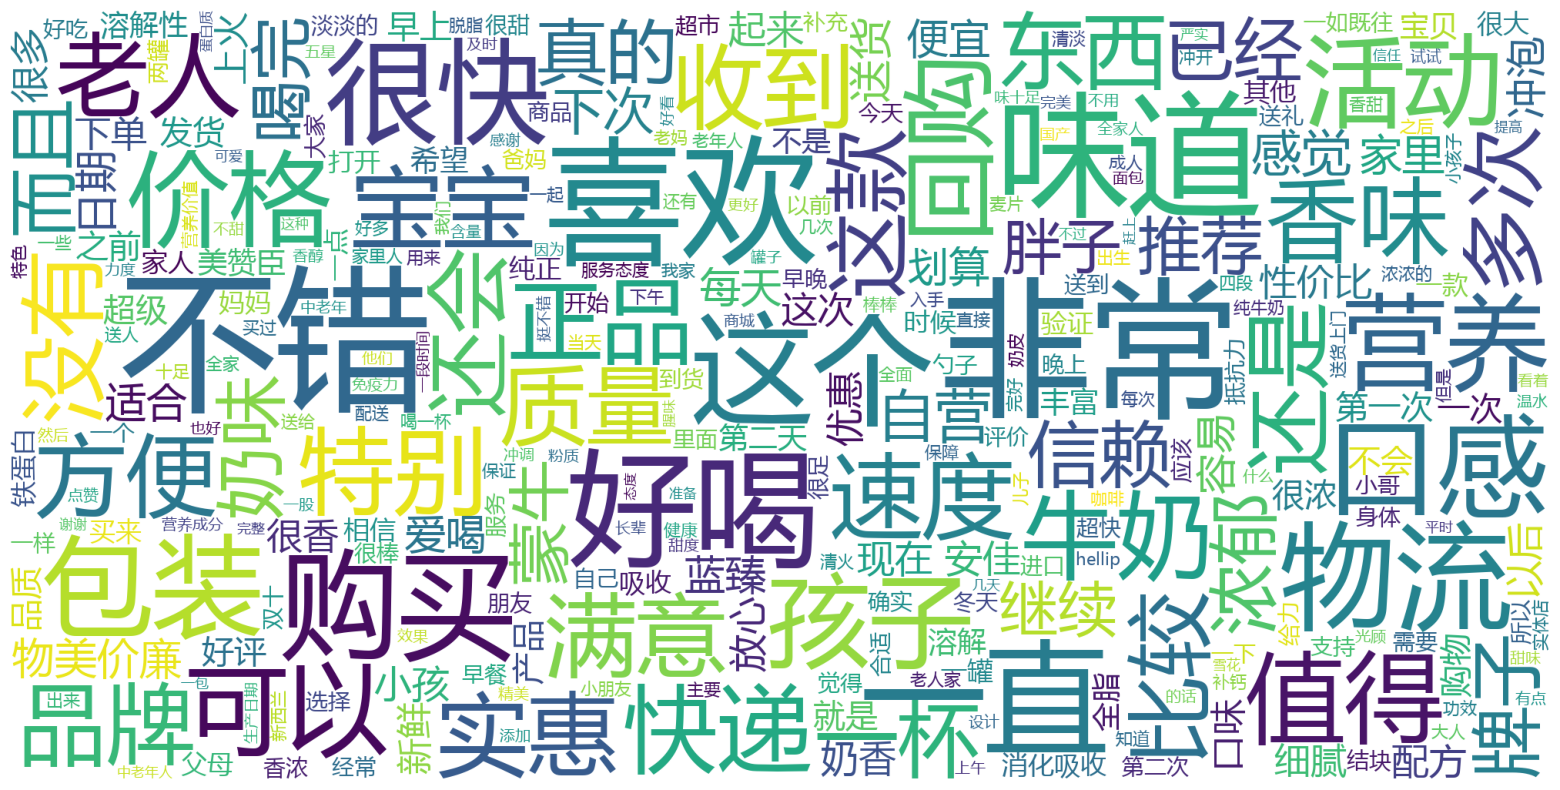

In [46]:
# 利用词频和TF-IDF挖掘正负文本中的关键点情况
# 利用tf-idf将文本转换为有权重的特征值
from sklearn.feature_extraction.text import TfidfVectorizer

pos=df[df['评论打分']==1]
neg=df[df['评论打分']==0]

# 创建对象
tv_pos_transfer=TfidfVectorizer()
tv_pos_data=tv_pos_transfer.fit_transform(list(pos['分词后']))

tv_neg_transfer=TfidfVectorizer()
tv_neg_data=tv_neg_transfer.fit_transform(list(neg['分词后']))

# 查看每个特征的情况
sorted_pos=sorted(tv_pos_transfer.vocabulary_.items(),key=lambda x:x[1])
sorted_pos=[i[0] for i in sorted_pos]

df_post=pd.DataFrame(tv_pos_data.toarray(),columns=sorted_pos)

# 根据权重排名，取出权重比较大的特征
pos_res=df_post.mean().sort_values(ascending=False)
pos_res[:50]
print(pos_res[:50])

# 绘制词云图
plt.figure(figsize=(20,10))
wordcloud=WordCloud(
    font_path='./工具/msyh.ttf',
    background_color='white',
    width=2000,
    height=1000,
    max_words=300,
    max_font_size=200
).generate_from_frequencies(pos_res) # 根据频率生成
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [47]:
# 计算共现的次数函数
#  主要是词语之间的关联性和上下文信息
def document(words):
    edge_dict={}
    for w in words:
        ws=w.split(' ')
        for i in range(len(ws)):
            now_w=ws[i]
            #取出其他词
            ws_s=ws[i:]
            for w_s in ws_s: # 循环遍历其他词
                a,b=now_w,w_s
                # 如果词相同
                if a==b:
                    continue
                if a>b:
                    a,b=b,a
                # 生成边
                key=a+','+b
                # 统计词频
                if key not in edge_dict:
                    edge_dict[key]=1
                else:
                    edge_dict[key]+=1
    df=pd.DataFrame([edge_dict]).T.reset_index()
    df.columns=['label','weight']
    df=df.sort_values(by='weight',ascending=False)
    # 拆分label标签
    df['source']=df['label'].map(lambda x:x.split(',')[0])
    df['target']=df['label'].map(lambda x:x.split(',')[1])
    return df
        

# 生成共现矩阵
pos_df=document(list(pos['分词后']))

pos_df

,label,weight,source,target
590,"很,的",9731,很,的
511,"了,的",9208,了,的
1976,"好,的",6137,好,的
1573,"喝,的",6000,喝,的
492,"了,很",5515,了,很
...,...,...,...,...
320447,"当,气味",1,当,气味
320446,"把,气味",1,把,气味
320444,"小孩子,气味",1,小孩子,气味
320443,"气味,现在",1,气味,现在


In [57]:
# 利用共现的矩阵查看具体一个词说了什么，得出关联的重要信息
def find_detail(word,start,end,df):
    target=[]
    source=[]
    x_df=df[df['weight'].map(lambda x:x<end and x>start)]
    for index,row in x_df.iterrows():
        if word==row['source']:
            print(x_df.loc[index]['target'])
            target.append(x_df.loc[index]['target'])
        if word==row['target']:
            print(x_df.loc[index]['source'])
            source.append(x_df.loc[index]['source'])
    print(target,source)


# 查看共现的情况
find_detail('国产',10,40,pos_df)

了
也
喝
买
是
不错
味道
比
有
我
一直
还是
就
支持
在
都
还
真的
喜欢
['是', '比', '有', '我', '还是', '就', '支持', '在', '都', '还', '真的'] ['了', '也', '喝', '买', '不错', '味道', '一直', '喜欢']


In [58]:
# 不满意权重
sorted_neg=sorted(tv_neg_transfer.vocabulary_.items(),key=lambda x:x[1])
sorted_neg=[i[0] for i in sorted_neg]

df_neg=pd.DataFrame(tv_neg_data.toarray(),columns=sorted_neg)
neg_res=df_neg.mean().sort_values(ascending=False)
neg_res[:50]


没有     0.039754
差评     0.028059
客服     0.024768
垃圾     0.022255
包装     0.019960
勺子     0.019731
味道     0.019589
知道     0.019204
东西     0.018916
快递     0.017453
收到     0.017441
这个     0.017212
一个     0.015377
一样     0.014583
什么     0.014438
打开     0.014384
为什么    0.013647
不好     0.013245
第一次    0.013214
降价     0.012775
感觉     0.012738
还是     0.012624
不是     0.012515
这样     0.012474
赠品     0.012465
就是     0.012344
里面     0.012171
而且     0.012085
这么     0.011587
假货     0.011557
之前     0.011492
价格     0.011337
商家     0.011332
一点     0.011292
怎么     0.011198
现在     0.010881
拉肚子    0.010774
购买     0.010221
活动     0.010097
直接     0.009966
产品     0.009902
一次     0.009698
以后     0.009628
一直     0.009623
怀疑     0.009615
不会     0.009091
有点     0.008943
结果     0.008877
那么     0.008727
不要     0.008704
dtype: float64

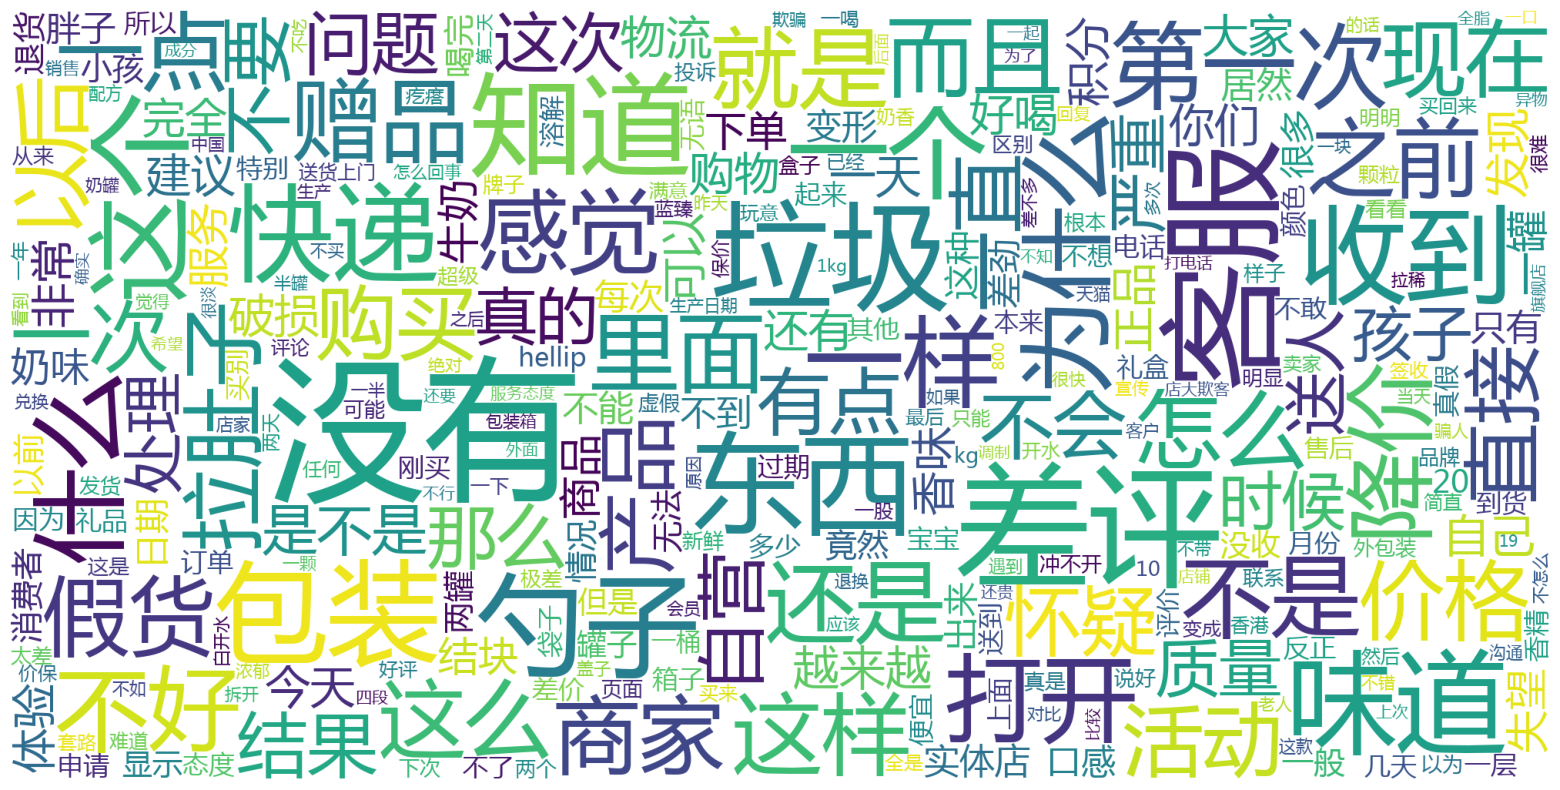

In [59]:
# 绘制词云图
# 绘制不满意情况
plt.figure(figsize=(20,10))
wordcloud=WordCloud(
    font_path='./工具/msyh.ttf',
    background_color='white',
    width=2000,
    height=1000,
    max_words=300,
    max_font_size=200
).generate_from_frequencies(neg_res) # 根据频率生成
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



In [61]:
# 利用文本挖掘相关算法找到平台中用户讨论得及重点
# 积极评论主题分析
from sklearn.decomposition import TruncatedSVD
tsvd=TruncatedSVD(n_components=5,algorithm='randomized',n_iter=100,random_state=1)
pos_topics=tsvd.fit_transform(tv_pos_data)

pos_topics

array([[ 0.17761665,  0.08843862,  0.10260306,  0.16769754,  0.0206852 ],
       [ 0.13872847, -0.05259614,  0.01278663, -0.01750326, -0.06408123],
       [ 0.07424165,  0.00349344,  0.01795058, -0.02754129, -0.03828541],
       ...,
       [ 0.04424702, -0.02648667, -0.03154193,  0.02889124,  0.01085823],
       [ 0.15653292, -0.0734372 , -0.02416933, -0.05443909,  0.05122848],
       [ 0.27909598, -0.18472559,  0.09752569, -0.41370133,  0.38293041]])

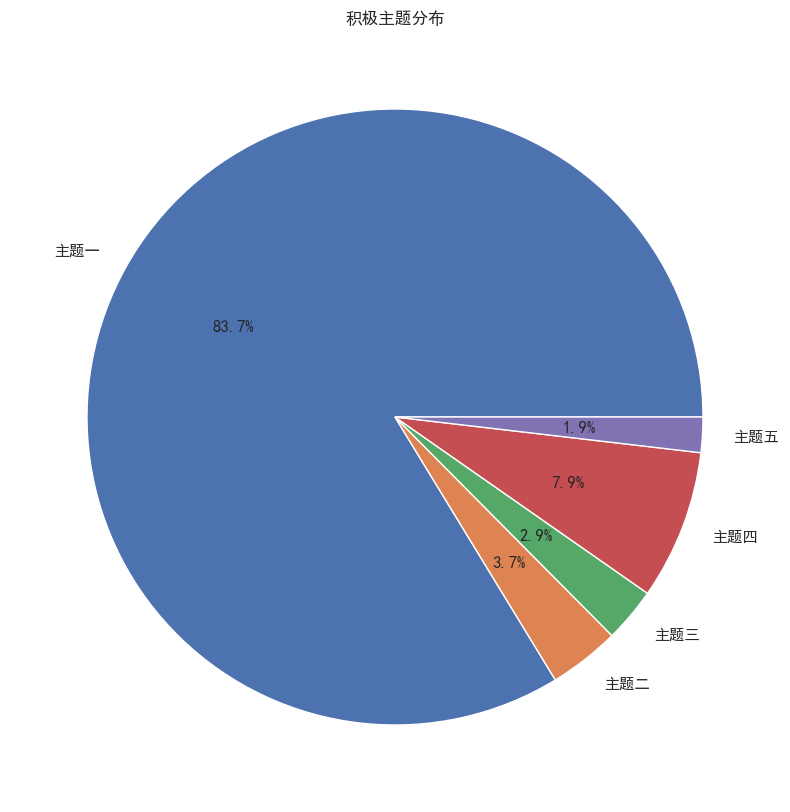

In [68]:
# 提取主题
terms=tv_pos_transfer.get_feature_names_out()
for i in range(3):
    # 取出当前主题词的权重
    weight=tsvd.components_[i]
    # 转化为字典
    dz=dict(zip(terms,weight))
    # 排序
    dz_s=sorted(dz.items(),key=lambda x:x[1],reverse=True)[:10]


# 查看分组情况数据
from collections import Counter
# 取出每一列的最大数对应的主题
res_pos=np.argmax(pos_topics,axis=1)
arr=Counter(res_pos)
arr2=dict(arr)
arr2

# 绘制饼图

plt.figure(figsize=(20,10))
lables=['主题一','主题二','主题三','主题四','主题五']
sizes=[4159,185,142,390,92]
plt.pie(
    sizes,
    labels=lables,
    autopct='%1.1f%%',
    shadow=False
)
plt.title('积极主题分布')
plt.show()




